<a href="https://colab.research.google.com/github/floranuta/Data_Circle/blob/Tetiana/notebooks/Task12_DataCleaningPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Path of the file to read
#csv_file_path = "D:/REDI/Data_Circle/data/training_set_values.csv"
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/training_set_values.csv"
# Fill in the line below to read the file into a variable home_data
pump_data = pd.read_csv(csv_file_path)
pump_data_labels=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training_set_labels.csv")
mask_invalid = (
    (pump_data["latitude"].isna()) |
    (pump_data["longitude"].isna()) |
    (pump_data["latitude"] < -12) |
    (pump_data["latitude"] > 0) |
    (pump_data["longitude"] < 29) |
    (pump_data["longitude"] > 41)
)

invalid_rows = pump_data[mask_invalid]
print(f"Number of invalid rows: {len(invalid_rows)}")
pump_data.drop(invalid_rows.index, inplace=True)
print(f"After deletion: {len(pump_data)} rows remain")

cols_to_drop = ["wpt_name","subvillage","waterpoint_type_group", "source_class", "source","quantity_group", "quality_group", "payment_type","management_group", "extraction_type_group", "extraction_type_class","scheme_name", "recorded_by", "public_meeting","num_private", "scheme_name"]
pump_data.drop(columns=cols_to_drop, inplace=True)
pump_data_merged = pd.merge(pump_data, pump_data_labels, on="id", how="left")


Mounted at /content/drive
Number of invalid rows: 1812
After deletion: 57588 rows remain


In [3]:
# Overview
def missing_report(df):
    missing_count = df.isnull().sum()
    missing_percent = 100 * df.isnull().mean()
    missing_table = (
        pd.DataFrame({
            "MissingCount": missing_count,
            "MissingPercent": missing_percent
        })
        .query("MissingCount > 0")  # оставить только с пропусками
        .sort_values(by="MissingCount", ascending=False)
    )
    return missing_table

missing_table = missing_report(pump_data_merged)
print(missing_table.to_string())

                   MissingCount  MissingPercent
scheme_management          3751        6.513510
installer                  3636        6.313815
funder                     3624        6.292978
permit                     3056        5.306661


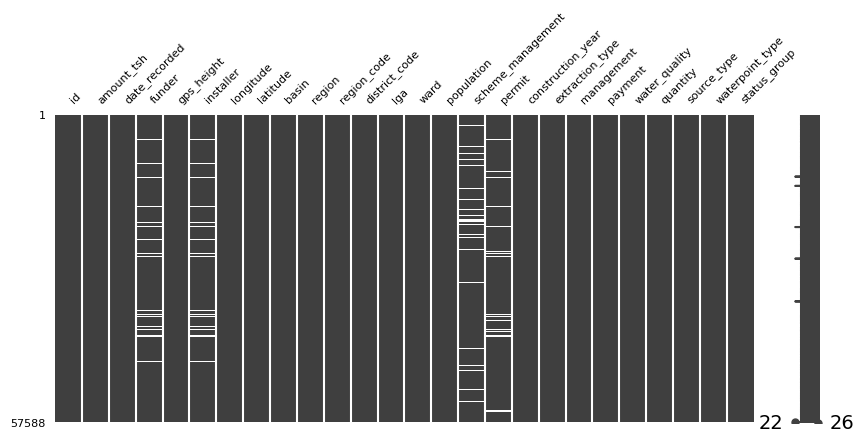

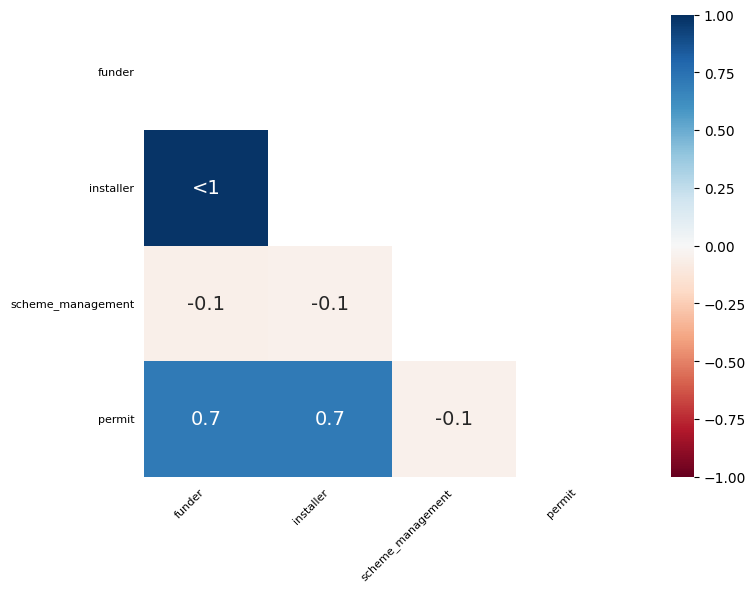

In [4]:
# Visualization
import missingno as msno
msno.matrix(pump_data_merged, figsize=(10,4))
plt.xticks(fontsize=8)   # уменьшаем подписи по X
plt.yticks(fontsize=8)   # уменьшаем подписи по Y
plt.show()
msno.heatmap(pump_data_merged, figsize=(8,6))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [5]:
def print_top10_per_null_column(df, top_n=10):
    # Select columns that contain at least one NaN
    null_cols = df.columns[df.isnull().any()].tolist()
    n_rows = len(df)

    for c in null_cols:
        # Count non-null values for the column
        vc = df[c].value_counts(dropna=True)

        print(f"\n===== {c} =====")  # column header

        if vc.empty:
            # Edge case: column has only NaNs
            print("No non-null values to display.")
            continue

        # Keep only top N
        vc = vc.head(top_n)

        # Percent relative to all rows (not just non-nulls)
        pct = (vc / n_rows * 100).round(2)

        # Build a compact table: value | count | percent
        out = (
            pd.DataFrame({
                "value": vc.index,
                "count": vc.values,
                "percent": pct.values
            })
        )

        # Pretty print without the dataframe index
        print(out.to_string(index=False))

# Usage
print_top10_per_null_column(pump_data_merged, top_n=10)


===== funder =====
                 value  count  percent
Government Of Tanzania   8842    15.35
                Danida   3114     5.41
                Hesawa   1914     3.32
            World Bank   1345     2.34
                  Kkkt   1287     2.23
          World Vision   1224     2.13
                 Rwssp   1187     2.06
                Unicef   1035     1.80
      District Council    843     1.46
                 Tasaf    834     1.45

===== installer =====
             value  count  percent
               DWE  16255    28.23
        Government   1670     2.90
               RWE   1181     2.05
             Commu   1060     1.84
            DANIDA   1050     1.82
              KKKT    897     1.56
            Hesawa    803     1.39
                 0    777     1.35
              TCRS    707     1.23
Central government    619     1.07

===== scheme_management =====
           value  count  percent
             VWC  36143    62.76
             WUG   4249     7.38
 Water author

In [6]:
pump_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57588 entries, 0 to 57587
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 57588 non-null  int64  
 1   amount_tsh         57588 non-null  float64
 2   date_recorded      57588 non-null  object 
 3   funder             53964 non-null  object 
 4   gps_height         57588 non-null  int64  
 5   installer          53952 non-null  object 
 6   longitude          57588 non-null  float64
 7   latitude           57588 non-null  float64
 8   basin              57588 non-null  object 
 9   region             57588 non-null  object 
 10  region_code        57588 non-null  int64  
 11  district_code      57588 non-null  int64  
 12  lga                57588 non-null  object 
 13  ward               57588 non-null  object 
 14  population         57588 non-null  int64  
 15  scheme_management  53837 non-null  object 
 16  permit             545

In [7]:
pump_data_merged.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source_type,waterpoint_type,status_group
0,69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,...,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional
1,8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,...,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,...,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
3,67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,...,True,1986,submersible,vwc,never pay,soft,dry,borehole,communal standpipe multiple,non functional
4,19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


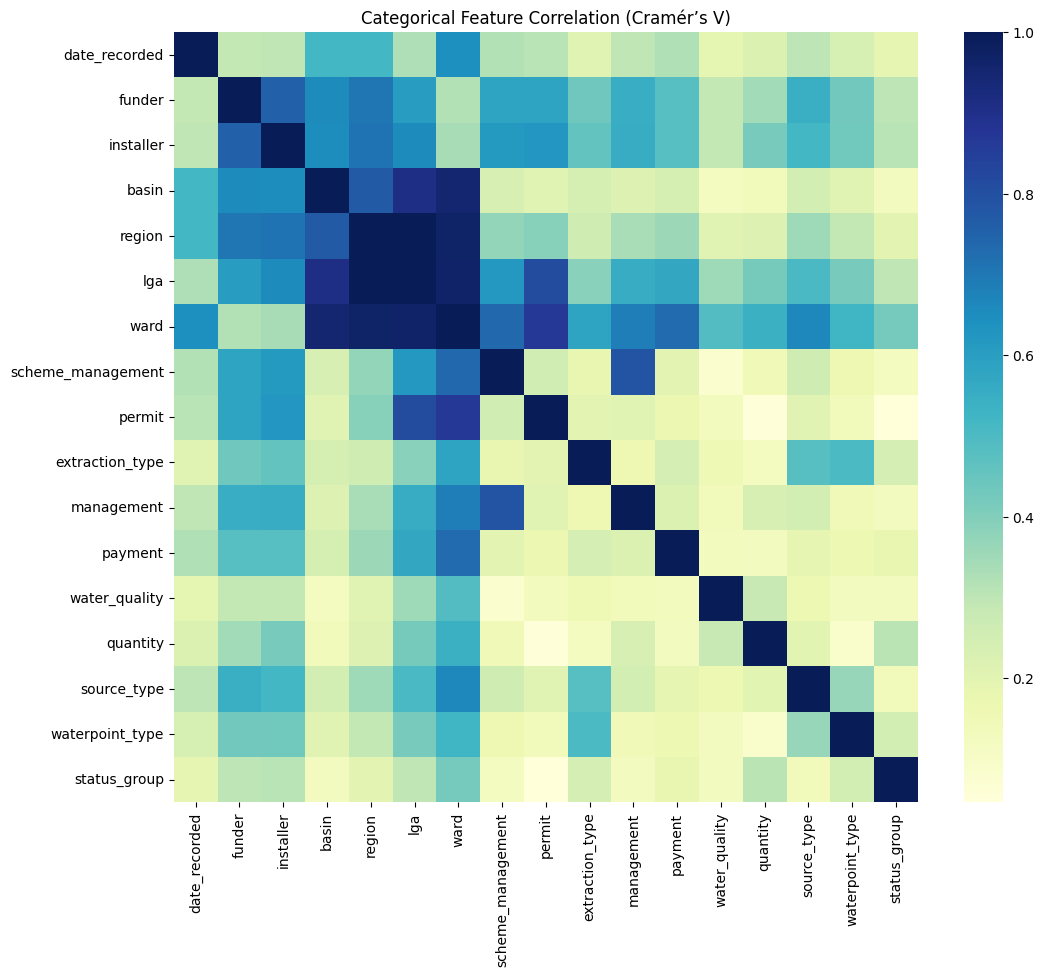

date_recorded        → Cramér’s V = 0.190
funder               → Cramér’s V = 0.301
installer            → Cramér’s V = 0.309
basin                → Cramér’s V = 0.127
region               → Cramér’s V = 0.198
lga                  → Cramér’s V = 0.299
ward                 → Cramér’s V = 0.425
scheme_management    → Cramér’s V = 0.120
permit               → Cramér’s V = 0.047
extraction_type      → Cramér’s V = 0.247
management           → Cramér’s V = 0.128
payment              → Cramér’s V = 0.184
water_quality        → Cramér’s V = 0.127
quantity             → Cramér’s V = 0.307
source_type          → Cramér’s V = 0.138
waterpoint_type      → Cramér’s V = 0.250
status_group         → Cramér’s V = 1.000


In [12]:
cat_cols = pump_data_merged.select_dtypes(include=['object']).columns.tolist()
from scipy.stats import chi2_contingency
import seaborn as sns
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cat_corr = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for c1 in cat_cols:
    for c2 in cat_cols:
        if c1 != c2:
            cat_corr.loc[c1, c2] = cramers_v(pump_data_merged[c1], pump_data_merged[c2])
        else:
            cat_corr.loc[c1, c2] = 1.0

plt.figure(figsize=(12,10))
sns.heatmap(cat_corr, cmap="YlGnBu")
plt.title("Categorical Feature Correlation (Cramér’s V)")
plt.show()
for c in cat_cols:
    val = cramers_v(pump_data_merged[c], pump_data_merged['status_group'])
    print(f"{c:20s} → Cramér’s V = {val:.3f}")

Numeric columns: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year']


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


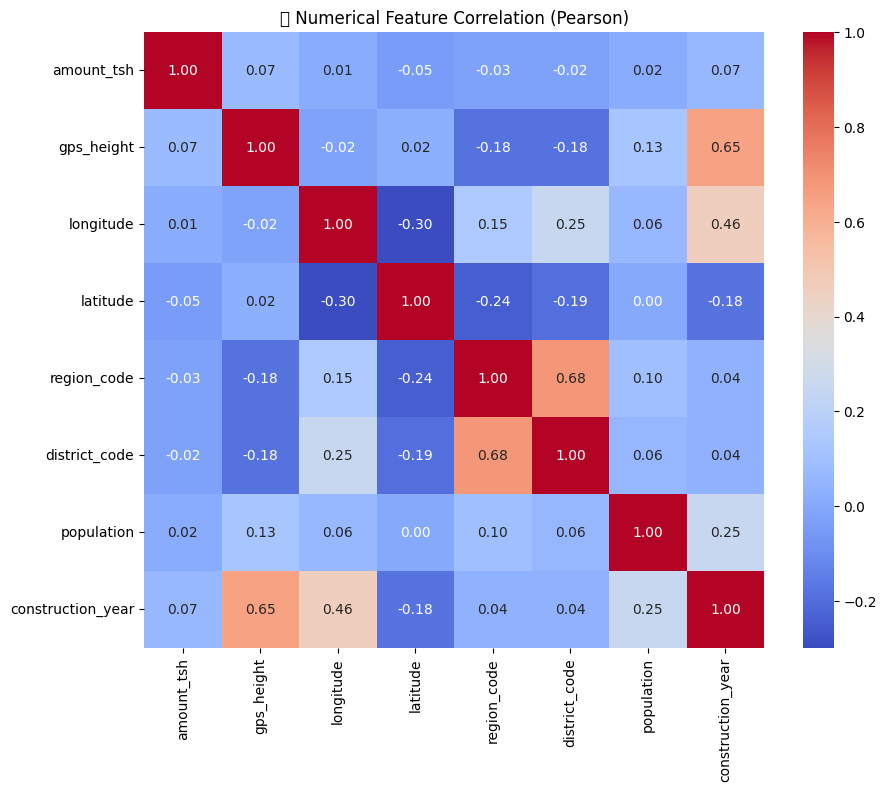

One-way ANOVA test
             feature  F_statistic        p_value  significant
1         gps_height   405.433223  1.415025e-175         True
4        region_code   351.999167  1.136611e-152         True
2          longitude   222.768382   4.219578e-97         True
5      district_code   138.291954   1.214344e-60         True
0         amount_tsh    85.673422   7.042915e-38         True
7  construction_year    67.248036   6.739109e-30         True
3           latitude    19.532449   3.311627e-09         True
6         population    10.177753   3.807493e-05         True
Kruskal-Wallis test
             feature  H_statistic        p_value  significant
0         amount_tsh  3027.394215   0.000000e+00         True
7  construction_year  1582.072352   0.000000e+00         True
1         gps_height   620.866046  1.515832e-135         True
4        region_code   372.599159   1.233447e-81         True
2          longitude   337.342879   5.583733e-74         True
5      district_code   108.1158

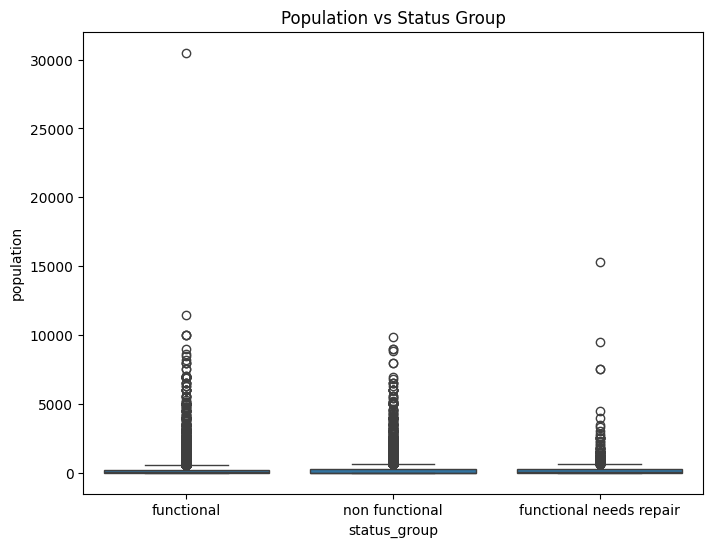

In [23]:
import scipy.stats as stats
num_cols = pump_data_merged.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Optional: remove id column (it’s just an identifier)
num_cols = [c for c in num_cols if c != 'id']
print("Numeric columns:", num_cols)
corr_matrix = pump_data_merged[num_cols].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Numerical Feature Correlation (Pearson)")
plt.show()

print("One-way ANOVA test")
target = 'status_group'
anova_results = []

for col in num_cols:
    groups = [group[col].dropna() for name, group in pump_data_merged.groupby(target)]
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append((col, f_stat, p_value))

anova_df = pd.DataFrame(anova_results, columns=['feature', 'F_statistic', 'p_value'])
anova_df['significant'] = anova_df['p_value'] < 0.05
anova_df.sort_values('p_value', inplace=True)

print(anova_df)
print("Kruskal-Wallis test")
kruskal_results = []

for col in num_cols:
    groups = [group[col].dropna() for name, group in pump_data_merged.groupby(target)]
    h_stat, p_value = stats.kruskal(*groups)
    kruskal_results.append((col, h_stat, p_value))

kruskal_df = pd.DataFrame(kruskal_results, columns=['feature', 'H_statistic', 'p_value'])
kruskal_df['significant'] = kruskal_df['p_value'] < 0.05
kruskal_df.sort_values('p_value', inplace=True)

print(kruskal_df)

plt.figure(figsize=(8,6))
sns.boxplot(x=target, y='population', data=pump_data_merged)
plt.title('Population vs Status Group')
plt.show()

In [8]:
# --- explicit lists ---
pump_data_imp = pump_data_merged.copy()
bool_cols = ["permit"]  # True/False only
cat_cols  = ["scheme_management", "installer",
             "funder"]  # other categoricals

# 1) Booleans: fill NaNs with column-wise mode (most frequent)
for c in bool_cols:
    mode_val = pump_data_merged[c].mode(dropna=True).iat[0]
    pump_data_imp[c] = pump_data_imp[c].fillna(mode_val)

# 2) Other categoricals: fill NaNs with "Unknown"
pump_data_imp[cat_cols] = pump_data_imp[cat_cols].fillna("Unknown")

# (Optional) quick check
print(pump_data_imp[bool_cols + cat_cols].isna().sum())

permit               0
scheme_management    0
installer            0
funder               0
dtype: int64


/tmp/ipython-input-96229888.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pump_data_imp[c] = pump_data_imp[c].fillna(mode_val)


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

bool_cols = ["permit"]
cat_cols  = ["scheme_management", "installer", "funder"]

preprocessor = ColumnTransformer(
    transformers=[
        ("bool_mode",   SimpleImputer(strategy="most_frequent"),                   bool_cols),
        ("cat_unknown", SimpleImputer(strategy="constant", fill_value="Unknown"),  cat_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False   # <- keep original column names
).set_output(transform="pandas")

# If sklearn >= 1.2, get a pandas DataFrame back (with column names)
preprocessor.set_output(transform="pandas")

# Fit on train; then use transform on any split for reproducibility
pump_data_imputed = preprocessor.fit_transform(pump_data_merged)

# Quick check
cols_to_check = bool_cols + cat_cols
#print(pump_data_imputed[cols_to_check].isna().sum())


In [10]:
print(cols_to_check)
print(type(pump_data_imputed))
print(pump_data_imputed.columns.tolist())
print(pump_data_imputed[cols_to_check].isna().sum())



['permit', 'scheme_management', 'installer', 'funder']
<class 'pandas.core.frame.DataFrame'>
['permit', 'scheme_management', 'installer', 'funder', 'id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'construction_year', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type', 'status_group']
permit               0
scheme_management    0
installer            0
funder               0
dtype: int64
